In [1]:
%matplotlib widget

import matplotlib
matplotlib.get_backend()


'module://ipympl.backend_nbagg'

IntSlider(value=0, description='Scrub', layout=Layout(width='99%'))

Output()

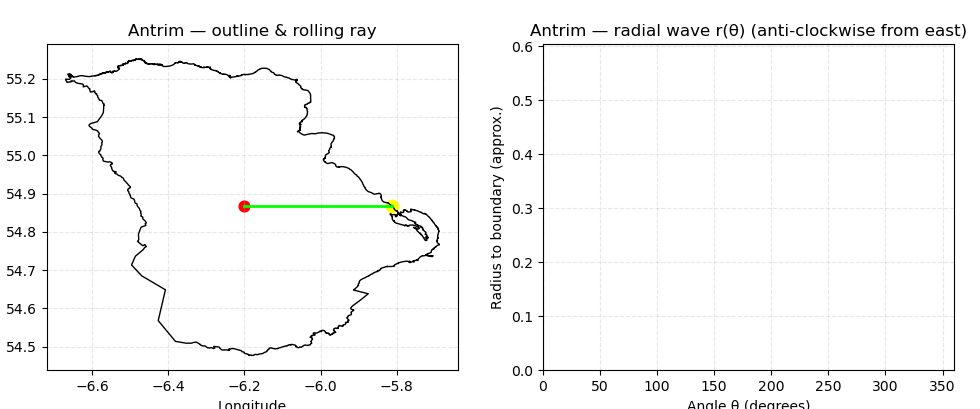

In [2]:
import json, math, time, asyncio
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output, Audio
import matplotlib

GEOJSON_PATH = "irish_counties.geojson"

# ---------- geometry helpers ----------
def _name(feat):
    p = feat.get("properties", {})
    for k in ("name_en","NAME","Name","name","COUNTY","County","county"):
        v = p.get(k)
        if isinstance(v, str) and v.strip():
            return v.strip()
    return str(p or feat.get("id") or "Unknown")

def _rings(g):
    t = g.get("type"); C = g.get("coordinates", [])
    conv = lambda r: [(float(x), float(y)) for x,y in r]
    out=[]
    if t=="Polygon":
        for r in C: out.append(conv(r))
    elif t=="MultiPolygon":
        for poly in C:
            for r in poly: out.append(conv(r))
    return out

def _signed_area(r): return 0.5*sum(x1*y2-x2*y1 for (x1,y1),(x2,y2) in zip(r, r[1:]))

def _ensure_ccw(r):
    r = r if r[0]==r[-1] else r+[r[0]]
    return r if _signed_area(r)>0 else r[::-1]

def _length(r): return sum(math.hypot(x2-x1,y2-y1) for (x1,y1),(x2,y2) in zip(r, r[1:]))

def _centroid(r):
    pts=r[:-1]; A=Cx=Cy=0.0
    for (x1,y1),(x2,y2) in zip(pts, pts[1:]+pts[:1]):
        cr=x1*y2-x2*y1; A+=cr; Cx+=(x1+x2)*cr; Cy+=(y1+y2)*cr
    A*=0.5
    if abs(A)<1e-12:
        xs,ys=zip(*pts); return sum(xs)/len(xs), sum(ys)/len(ys)
    return Cx/(6*A), Cy/(6*A)

def _seg_horiz_intersection(p1,p2,y):
    (x1,y1),(x2,y2)=p1,p2
    if y<min(y1,y2) or y>max(y1,y2): return None
    dy=y2-y1
    if abs(dy)<1e-12: return None
    t=(y-y1)/dy
    if t<0 or t>1: return None
    return (x1+t*(x2-x1), y)

def _start_east(r, c):
    cx,cy=c
    cand=[]
    for i in range(len(r)-1):
        hit=_seg_horiz_intersection(r[i], r[i+1], cy)
        if hit is not None and hit[0]>=cx-1e-12:
            cand.append((i,hit))
    if not cand:
        idx=max(range(len(r)-1), key=lambda k: r[k][0])
        start=r[idx]; pts=r[:-1]
        new=[start]+pts[idx+1:]+pts[:idx]+[start]
        return new, start
    i_edge, start = sorted(cand, key=lambda t:(t[1][0]-cx))[0]
    pts=r[:-1]
    new=pts[:i_edge+1]+[start]+pts[i_edge+1:]
    new=new[i_edge+1:]+new[:i_edge+1]
    new.append(new[0])
    return new, start

def _radial_arrays(closed_points, c):
    pts = closed_points[:-1]; cx,cy=c
    theta=[math.atan2(y-cy,x-cx) for x,y in pts]
    uw=[theta[0]]
    for t in theta[1:]:
        prev=uw[-1]; dt=t-prev
        while dt<=-math.pi: dt+=2*math.pi
        while dt> math.pi:  dt-=2*math.pi
        uw.append(prev+dt)
    shift=uw[0]; uw=[t-shift for t in uw]
    r=[math.hypot(x-cx,y-cy) for x,y in pts]
    return np.array(uw), np.array(r), np.array(pts)

# ---------- load ----------
with open(GEOJSON_PATH,"r",encoding="utf-8") as f:
    data=json.load(f)
features=data["features"]
name_to_feat={_name(f):f for f in features}
county_names=sorted(name_to_feat.keys())

# ---------- scales & keys ----------
SCALES = {
    "Algerian":[0,2,3,6,7,8,11],
    "Arabic":[0,1,4,5,7,8,11],
    "Balinese Pelog":[0,1,3,7,8],
    "Blues":[0,3,5,6,7,10],
    "Chromatic":list(range(12)),
    "Dorian":[0,2,3,5,7,9,10],
    "Harmonic Minor":[0,2,3,5,7,8,11],
    "Irish (D Mixolydian pentatonic)":[0,2,4,7,9],   # handy preset
    "Lydian":[0,2,4,6,7,9,11],
    "Major":[0,2,4,5,7,9,11],
    "Minor":[0,2,3,5,7,8,10],
    "Mixolydian":[0,2,4,5,7,9,10],
    "Phrygian":[0,1,3,5,7,8,10],
    "Whole Tone":[0,2,4,6,8,10],
}
KEYS = {
    "C4":261.63, "C#4/Db4":277.18, "D4":293.66, "D#4/Eb4":311.13, "E4":329.63,
    "F4":349.23, "F#4/Gb4":369.99, "G4":392.00, "G#4/Ab4":415.30,
    "A4":440.00, "A#4/Bb4":466.16, "B4":493.88,
}

# ---------- widgets ----------
dd = widgets.Dropdown(options=county_names, description="County:", layout=widgets.Layout(width="24%"))
play = widgets.Play(value=0, min=0, max=100, step=25, interval=1, description="▶︎")
step = widgets.BoundedIntText(description="Step", value=25, min=1, max=200, layout=widgets.Layout(width="12%"))
reset = widgets.Button(description="Reset")
btn_make = widgets.Button(description="Make & Play")
duration_box = widgets.FloatText(description="Duration (s)", value=10.0, layout=widgets.Layout(width="18%"))
key_dropdown = widgets.Dropdown(description="Key", options=[(k,v) for k,v in KEYS.items()], value=KEYS["D4"], layout=widgets.Layout(width="18%"))
scale_dropdown = widgets.Dropdown(description="Scale", options=sorted(SCALES.keys()), value="Major", layout=widgets.Layout(width="28%"))
scrub = widgets.IntSlider(description="Scrub", value=0, min=0, max=100, step=1, continuous_update=True, layout=widgets.Layout(width="99%"))

# "transport" for the red vline (plot-side player)
t_slider = widgets.FloatSlider(description="t (s)", value=0.0, min=0.0, max=10.0, step=0.01, readout=True, readout_format=".2f", layout=widgets.Layout(width="60%"))
btn_play = widgets.ToggleButton(value=False, description="Play", icon="play")
btn_reset_line = widgets.Button(description="Reset line")

widgets.jslink((play, 'value'), (scrub, 'value'))
display(widgets.HBox([dd, play, step, reset, btn_make]),
        widgets.HBox([duration_box, key_dropdown, scale_dropdown]),
        widgets.HBox([t_slider, btn_play, btn_reset_line]),
        scrub)

audio_out = widgets.Output()
display(audio_out)

# ---------- figure ----------
fig, (axL, axR) = plt.subplots(1, 2, figsize=(9.8, 4.1))
plt.tight_layout(w_pad=3, rect=(0, 0, 1, 0.94))
try: fig.canvas.header_visible = False
except Exception: pass

line_tr, = axL.plot([], [], linewidth=2.0, color='green')
ray,     = axL.plot([], [], linewidth=2.0, color='lime')
wave,    = axR.plot([], [], linewidth=1.0, color='green')
centroid_dot = axL.scatter([], [], s=60, color='red')
start_dot    = axL.scatter([], [], s=80, color='yellow')
vline = axR.axvline(0, color='red', linestyle='--', alpha=0.85); vline.set_visible(False)

STATE={"pts":None,"theta_deg":None,"r":None,"c":None,"N":0,"name":None,
       "bins_chords":None,"th_min":None,"th_max":None,"num_bins":None,
       "duration":10.0,"sr":44100,"audio":None}
TASK={"anim":None}

# ---------- prep ----------
def prepare(name):
    f = name_to_feat[name]
    ring = _ensure_ccw(max(_rings(f["geometry"]), key=_length))
    c = _centroid(ring)
    ring2, start = _start_east(ring, c)   # always anti-clockwise

    theta, r, pts = _radial_arrays(ring2, c)
    theta_deg = np.degrees(theta)

    # left
    axL.clear()
    X=[p[0] for p in ring2]; Y=[p[1] for p in ring2]
    axL.plot(X, Y, linewidth=1.0, color='black'); axL.set_aspect("equal","datalim")
    axL.set_title(f"{name} — outline & rolling ray")
    axL.set_xlabel("Longitude"); axL.set_ylabel("Latitude"); axL.grid(True, linestyle="--", alpha=0.3)
    global line_tr, ray, centroid_dot, start_dot
    (line_tr,) = axL.plot([], [], linewidth=2.0, color='green')
    (ray,)     = axL.plot([c[0], start[0]], [c[1], start[1]], linewidth=2.0, color='lime')
    centroid_dot = axL.scatter([c[0]],[c[1]], s=60, color='red')
    start_dot    = axL.scatter([start[0]],[start[1]], s=80, color='yellow')

    # right
    axR.clear()
    axR.set_title(f"{name} — radial wave r(θ) (anti-clockwise from east)")
    axR.set_xlabel("Angle θ (degrees)"); axR.set_ylabel("Radius to boundary (approx.)")
    axR.grid(True, linestyle="--", alpha=0.3)
    axR.set_xlim(0, max(360, theta_deg.max())); axR.set_ylim(0, r.max()*1.05)
    global wave, vline
    (wave,) = axR.plot([], [], linewidth=1.0, color='green')
    vline = axR.axvline(0, color='red', linestyle='--', alpha=0.85); vline.set_visible(True)

    # angle bins -> chords (polyphony)
    num_bins = min(720, len(theta_deg))
    th_min, th_max = float(theta_deg.min()), float(theta_deg.max())
    if th_max - th_min < 1e-6: th_min, th_max = 0.0, 360.0
    bins = [[] for _ in range(num_bins)]
    for ang,rad in zip(theta_deg, r):
        k = int((ang - th_min)/(th_max - th_min + 1e-9) * (num_bins - 1))
        k = max(0, min(num_bins-1, k))
        bins[k].append(rad)
    # fill empty bins from neighbours to keep continuity
    last=None
    for i in range(num_bins):
        if bins[i]: last=bins[i]
        elif last is not None: bins[i]=last
    last=None
    for i in range(num_bins-1,-1,-1):
        if bins[i]: last=bins[i]
        elif last is not None: bins[i]=last

    scrub.min = 0; scrub.max = len(pts)-1; scrub.value = 0
    play.min  = 0; play.max  = len(pts)-1; play.value  = 0
    play.step = int(step.value); play.interval = 1

    t_slider.min = 0.0; t_slider.max = float(duration_box.value); t_slider.value = 0.0

    STATE.update(dict(pts=pts, theta_deg=theta_deg, r=r, c=c, N=len(pts), name=name,
                      bins_chords=bins, th_min=th_min, th_max=th_max,
                      num_bins=num_bins, duration=float(duration_box.value)))
    fig.canvas.draw_idle()

def update_from_index(i):
    if STATE["pts"] is None: return
    i = int(np.clip(i, 0, STATE["N"]-1))
    pts = STATE["pts"]; c = STATE["c"]
    line_tr.set_data(pts[:i+1,0], pts[:i+1,1])
    ray.set_data([c[0], pts[i,0]], [c[1], pts[i,1]])
    wave.set_data(STATE["theta_deg"][:i+1], STATE["r"][:i+1])
    fig.canvas.draw_idle()
    if "widget" not in matplotlib.get_backend().lower(): plt.pause(0.001)

# ---------- mapping: radius bins -> frequencies (scale/key), K voices ----------
def _bins_to_freq_matrix(bins_r, base_freq, scale_name, N_samples, sr, K=3, smooth_ms=5):
    # scale notes (in MIDI), root from base_freq
    root_midi = 69 + 12.0*np.log2(base_freq/440.0)
    scale_semi = np.array(SCALES.get(scale_name, SCALES["Chromatic"]), dtype=float)
    octaves = np.array([0,12,24], dtype=float)
    scale_notes = (root_midi + scale_semi[None,:] + octaves[:,None]).ravel()
    scale_notes = np.unique(np.clip(np.round(scale_notes), 0, 127)).astype(int)

    # global r range
    all_r = np.array([x for bl in bins_r for x in bl], dtype=float)
    rmin, rmax = all_r.min(), all_r.max()

    # for each bin, quantize each radius -> nearest note in scale
    chords = []
    for bl in bins_r:
        notes=[]
        for rad in bl:
            norm = (rad - rmin) / (rmax - rmin + 1e-9)
            idx = int(round(norm*(len(scale_notes)-1)))
            idx = max(0, min(len(scale_notes)-1, idx))
            notes.append(scale_notes[idx])
        # pick up to K distinct notes: low/mid/high if available
        uniq = sorted(set(notes))
        if len(uniq)>K:
            pick=[uniq[0], uniq[len(uniq)//2], uniq[-1]]
        else:
            pick=uniq
        chords.append(pick)

    # map time indices to bins
    pos_t = np.linspace(0,1,N_samples)
    b_idx = (pos_t*(len(chords)-1)).round().astype(int)

    # build freq matrix [K, N_samples], pad/repeat as needed
    freqs = np.full((K, N_samples), np.nan, dtype=float)
    last = [np.nan]*K
    for n,tb in enumerate(b_idx):
        chord = chords[tb]
        # fill columns by sorted order
        for k in range(K):
            if k < len(chord):
                midi = chord[k]
                freqs[k,n] = 440.0 * 2.0**((midi-69)/12.0)
            else:
                freqs[k,n] = np.nan
        # carry forward missing voices to avoid dropouts
        for k in range(K):
            if np.isnan(freqs[k,n]):
                freqs[k,n] = last[k]
        last = freqs[:,n].tolist()

    # small smoothing to reduce clicks
    win = max(1, int(smooth_ms*sr/1000))
    if win>1:
        from numpy.lib.stride_tricks import sliding_window_view as SWV
        for k in range(K):
            f = freqs[k]
            mask = np.isnan(f)
            if np.all(mask): continue
            # interpolate NaNs
            good = ~mask
            f[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(good), f[good])
            if len(f)>=win:
                w = np.ones(win)/win
                freqs[k] = np.convolve(f, w, mode='same')

    return freqs

def make_audio_polyphonic(duration, base_freq, scale_name, sr=44100, K=3):
    N = int(max(0.1, duration)*sr)
    freqs = _bins_to_freq_matrix(STATE["bins_chords"], base_freq, scale_name, N, sr, K=K)
    # integrate phases per voice and sum
    audio = np.zeros(N, dtype=np.float32)
    for k in range(freqs.shape[0]):
        f = freqs[k]
        if np.all(np.isnan(f)): continue
        f = np.nan_to_num(f, nan=np.nanmean(f) if np.isfinite(np.nanmean(f)) else 0.0)
        phase = np.cumsum(2*np.pi*f/sr, dtype=np.float64)
        audio += np.sin(phase, dtype=np.float64).astype(np.float32)

    # soft limiter for consistent loudness
    audio = np.tanh(0.6*audio)
    # tiny fade
    L = int(0.01*sr)
    if L>0 and 2*L<len(audio):
        ramp = np.linspace(0,1,L)
        audio[:L] *= ramp; audio[-L:] *= ramp[::-1]
    # normalise
    m = np.max(np.abs(audio))+1e-9
    audio = (audio/m).astype(np.float32)
    return audio, sr

# ---------- play / animate ----------
async def animate_vline():
    # drive vline from t_slider while btn_play is on
    vline.set_visible(True); fig.canvas.draw_idle()
    t0 = time.perf_counter() - t_slider.value
    dur = STATE["duration"]; th_min, th_max = STATE["th_min"], STATE["th_max"]
    while btn_play.value:
        t = time.perf_counter() - t0
        if t > dur:
            t = dur
            btn_play.value = False
        t_slider.value = t
        frac = (t/dur) if dur>1e-9 else 0.0
        x = th_min + frac*(th_max - th_min)
        vline.set_xdata([x,x]); fig.canvas.draw_idle()
        await asyncio.sleep(0.01)

def on_make_clicked(_):
    if STATE["bins_chords"] is None: return
    dur = float(duration_box.value); STATE["duration"]=dur
    base = float(key_dropdown.value); scale = scale_dropdown.value
    audio, sr = make_audio_polyphonic(dur, base, scale, sr=44100, K=3)
    STATE["audio"]=audio; STATE["sr"]=sr
    t_slider.min=0.0; t_slider.max=dur; t_slider.value=0.0
    with audio_out:
        clear_output(wait=True)
        display(Audio(audio, rate=sr, autoplay=True))  # browser player

def on_t_slider_change(change):
    if change["name"]=="value":
        dur = STATE["duration"]; th_min, th_max = STATE["th_min"], STATE["th_max"]
        t = float(change["new"]); frac = (t/dur) if dur>1e-9 else 0.0
        x = th_min + frac*(th_max - th_min)
        vline.set_xdata([x,x]); fig.canvas.draw_idle()

def on_btn_play(change):
    if change["name"]=="value":
        if change["new"]:
            btn_play.description="Pause"; btn_play.icon="pause"
            if TASK["anim"] is None or TASK["anim"].done():
                TASK["anim"]=asyncio.create_task(animate_vline())
        else:
            btn_play.description="Play"; btn_play.icon="play"

def on_reset_line(_):
    btn_play.value=False
    t_slider.value=0.0

# ---- UI wiring ----
def _on_scrub(change):
    if change["name"]=="value": update_from_index(change["new"])
def _on_play(change):
    if change["name"]=="value":
        scrub.value = change["new"]; update_from_index(change["new"])
def _on_step(change):
    if change["name"]=="value": play.step = int(change["new"])
def _on_county(change):
    if change["name"]=="value": prepare(change["new"])
def _on_reset(_):
    play.value = 0; update_from_index(0)

scrub.observe(_on_scrub, names="value")
play.observe(_on_play, names="value")
step.observe(_on_step, names="value")
dd.observe(_on_county, names="value")
reset.on_click(_on_reset)
btn_make.on_click(on_make_clicked)
t_slider.observe(on_t_slider_change, names="value")
btn_play.observe(on_btn_play, names="value")
btn_reset_line.on_click(on_reset_line)

# click on right plot to jump the scrub line
def _onclick(event):
    if event.inaxes is not axR: return
    x = event.xdata
    th_min, th_max = STATE["th_min"], STATE["th_max"]
    frac = (x - th_min) / (th_max - th_min + 1e-9)
    frac = np.clip(frac, 0, 1)
    t_slider.value = float(frac * STATE["duration"])
cid = fig.canvas.mpl_connect('button_press_event', _onclick)

# init
prepare(dd.value)
update_from_index(0)
